In [4]:
import sys
import pathlib
cwd = pathlib.Path().cwd()
sys.path.append(cwd.parent.as_posix())
data_folder = cwd.parent.joinpath('data')

import pickle
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from functools import partial
from sklearn.metrics import f1_score

In [5]:
# calc proba
model = pickle.load(open('model.pkl', 'rb'))

# select part of train
train = pd.read_csv(data_folder.joinpath('data_train.csv')).drop('Unnamed: 0', axis=1)
train = train[train['buy_time'] >= dt.datetime.fromisoformat('2018-11-19').timestamp()]

data = train.drop('target', axis=1)
target = train['target']

proba = model.predict_proba(data)

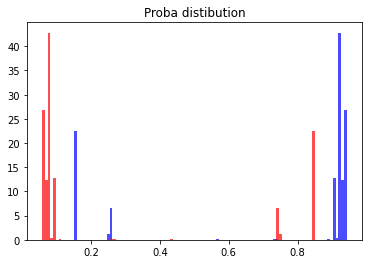

In [6]:
# proba distribution figure
plt.title('Proba distibution')
plt.hist(proba.T[0], bins=100, color='blue', alpha=0.7, density=True);
plt.hist(proba.T[1], bins=100, color='red', alpha=0.7, density=True);

## ROC-curve

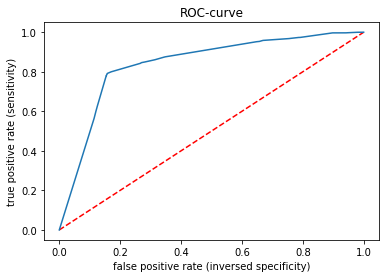

In [4]:
fpr, tpr, thr = roc_curve(target, proba.T[1])
plt.title('ROC-curve')
plt.xlabel('false positive rate (inversed specificity)')
plt.ylabel('true positive rate (sensitivity)')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.plot(fpr, tpr);

Хотя очевидно, что порог в данном случае однозначен, попробуем найти его разными методами.

In [33]:
idx = [None, None, None]

In [34]:
# A: max(tpr) & min(fpr)
idx[0] = ((fpr + 1) / (tpr + 1)).argmin()
print(f'sensitivity = {tpr[idx[0]]}', f'specificity = {1 - fpr[idx[0]]}', f'threshold = {thr[idx[0]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[0]]) * 1, average='macro'))

sensitivity = 0.7918084467574059
specificity = 0.8420163903969614
threshold = 0.10729328367655484
0.7367590595749578


In [35]:
# B: max(sensitivity + specificity)
idx[1] = (1 - fpr + tpr).argmax()
print(f'sensitivity = {tpr[idx[1]]}', f'specificity = {1 - fpr[idx[1]]}', f'threshold = {thr[idx[1]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[1]]) * 1, average='macro'))

sensitivity = 0.7918084467574059
specificity = 0.8420163903969614
threshold = 0.10729328367655484
0.7367590595749578


In [36]:
# C: G-mean
idx[2] = np.sqrt(tpr * (1 - fpr)).argmax()
print(f'sensitivity = {tpr[idx[2]]}', f'specificity = {1 - fpr[idx[2]]}', f'threshold = {thr[idx[2]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[0]]) * 1, average='macro'))

sensitivity = 0.7918084467574059
specificity = 0.8420163903969614
threshold = 0.10729328367655484
0.7367590595749578


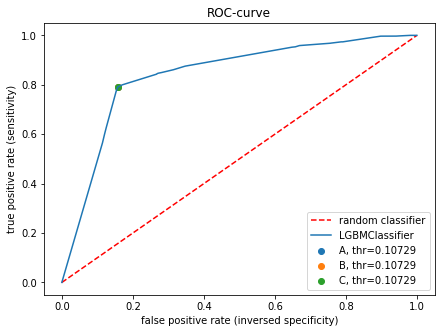

In [41]:
fpr, tpr, thr = roc_curve(target, proba.T[1])
fig, ax = plt.subplots(figsize=(7, 5))
plt.title('ROC-curve')
plt.xlabel('false positive rate (inversed specificity)')
plt.ylabel('true positive rate (sensitivity)')
plt.plot([0, 1], [0, 1], '--', color='red', label='random classifier')
plt.plot(fpr, tpr, label='LGBMClassifier')
for n, i in enumerate(idx):
    ax.scatter(fpr[i], tpr[i], label=f'{chr(65 + n)}, thr={thr[i].round(5)}')
    # ax.annotate(chr(65 + n), [fpr[i], tpr[i] + 0.05 * (-1) ** (n // 2)])
plt.legend();

Все три метода дали одинаковый результат, что было ожидаемо.

Оптимальный `threshold` по TPR/FPR $\approx$ `0.10729`.<br>
`f1` $\approx$ `0.73676`

## PR-curve

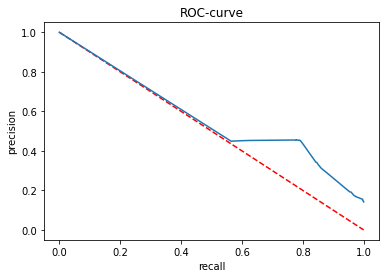

In [10]:
pr, rc, thr = precision_recall_curve(target, proba.T[1])
plt.title('ROC-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot([0, 1], [1, 0], '--', color='red')
plt.plot(rc, pr);

In [46]:
idx = [None, None]

In [47]:
# A: max(sensitivity + specificity)
idx[0] = (pr + rc).argmax()
print(f'precision = {pr[idx[0]]}', f'recall = {rc[idx[0]]}', f'threshold = {thr[idx[0]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[0]]) * 1, average='macro'))

precision = 0.45266259493942473
recall = 0.7918084467574059
threshold = 0.09308357921376408
0.6605584842985982


In [48]:
# B: G-mean
idx[1] = np.sqrt(pr * rc).argmax()
print(f'precision = {pr[idx[1]]}', f'recall = {rc[idx[1]]}', f'threshold = {thr[idx[1]]}', sep='\n')
print(f1_score(target, (proba.T[1] >= thr[idx[1]]) * 1, average='macro'))

precision = 0.45266259493942473
recall = 0.7918084467574059
threshold = 0.09308357921376408
0.6605584842985982


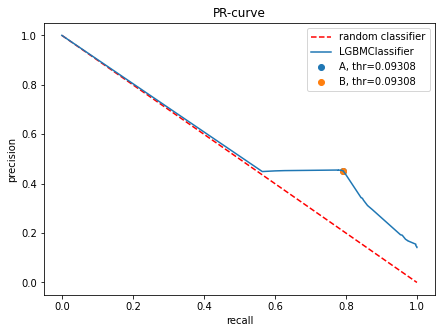

In [49]:
fpr, tpr, thr = roc_curve(target, proba.T[1])
fig, ax = plt.subplots(figsize=(7, 5))
plt.title('PR-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot([0, 1], [1, 0], '--', color='red', label='random classifier')
plt.plot(rc, pr, label='LGBMClassifier')
for n, i in enumerate(idx):
    ax.scatter(rc[i], pr[i], label=f'{chr(65 + n)}, thr={thr[i].round(5)}')
    # ax.annotate(chr(65 + n), [fpr[i], tpr[i] + 0.05 * (-1) ** (n // 2)])
plt.legend();

Оптимальный `threshold` по precision/recall $\approx$ `0.093`.<br>
`f1` $\approx$ `0.66056`

## tmp

In [20]:
# функция метрики от выбранного threshold
def thr_metric_func(threshold, *, y_true, proba):
    return f1_score(y_true, (proba >= threshold) * 1, average='macro')

thr_metric = np.vectorize(partial(thr_metric_func, y_true=target, proba=proba.T[1]))

In [21]:
thr_metric(np.linspace(0.2120, 0.2122, 5))

array([0.73655055, 0.73655055, 0.73655055, 0.73655055, 0.73655055])

In [12]:
#